In [104]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [106]:
listings_df = pd.read_csv("listings.csv")
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [107]:
#dropping unused columns

drop_columns = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','host_has_profile_pic','street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state','zipcode','market','smart_location','country_code','country', 'latitude','longitude','has_availability','availability_30','availability_60','availability_90','calendar_last_scraped','requires_license','license','jurisdiction_names','require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count','reviews_per_month','host_location','host_response_time','host_acceptance_rate','host_listings_count','host_total_listings_count','calendar_updated','first_review']

listings_df = listings_df.drop(drop_columns,axis=1)

In [108]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_since                   3816 non-null   object 
 1   host_response_rate           3295 non-null   object 
 2   host_is_superhost            3816 non-null   object 
 3   host_identity_verified       3816 non-null   object 
 4   is_location_exact            3818 non-null   object 
 5   property_type                3817 non-null   object 
 6   room_type                    3818 non-null   object 
 7   accommodates                 3818 non-null   int64  
 8   bathrooms                    3802 non-null   float64
 9   bedrooms                     3812 non-null   float64
 10  beds                         3817 non-null   float64
 11  bed_type                     3818 non-null   object 
 12  amenities                    3818 non-null   object 
 13  square_feet       

In [109]:
#changing a few columns

def change_bool(x):
    if x == 't':
        x = x.replace('t','1')
    elif x == 'f':
        x = x.replace('f','0')
    else:
        x = '0'
    return int(x)

def change_cent(x):
    if type(x) == str:
        x = x.replace('%','')
    return x

def change_price (x):
    if type(x) == str:
        x = x.replace('$','')
        x = x.replace(',','')
    return x

def change_amenities(x):
    val = x.replace('{','').replace(' ','_').replace(',',' ').replace('"','').replace('/','_').replace('}','')
    val = val.split(' ')
    return val

def length_amen (x):
    x = len(x)
    return x


for i in listings_df.columns:
    if set(listings_df[i]) == {'t','f','NaN'}:
        listings_df[i] = listings_df[i].apply(lambda x:change_bool(x))
    elif set(listings_df[i]) == {'t','f'}:
        listings_df[i] = listings_df[i].apply(lambda x:change_bool(x))

listings_df['host_is_superhost'] = listings_df['host_is_superhost'].apply(lambda x:change_bool(x)) 
listings_df['host_identity_verified'] = listings_df['host_identity_verified'].apply(lambda x:change_bool(x)) 

listings_df['price'] = listings_df['price'].apply(lambda x:change_price(x))
listings_df['weekly_price'] = listings_df['weekly_price'].apply(lambda x:change_price(x))
listings_df['monthly_price'] = listings_df['monthly_price'].apply(lambda x:change_price(x))
listings_df['security_deposit'] = listings_df['security_deposit'].apply(lambda x:change_price(x))
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].apply(lambda x:change_price(x))
listings_df['extra_people'] = listings_df['extra_people'].apply(lambda x:change_price(x))


listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(lambda x:change_cent(x))

listings_df['amenities'] = listings_df['amenities'].apply(lambda x:change_amenities(x))
listings_df['amenities'] = listings_df['amenities'].apply(lambda x:length_amen(x))


def change_dtype(x):
    x = float(x)
    return x

col = ['host_response_rate','price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for i in col:
    listings_df[i] = listings_df[i].apply(lambda x:change_dtype(x))

def extract_year(row):     #extracting year from date string
    if type(row)==str:
        return float(row.split('-')[0])
listings_df['host_since'] = listings_df['host_since'].apply(lambda x:extract_year(x))
listings_df['last_review'] = listings_df['last_review'].apply(lambda x:extract_year(x))



In [110]:
for i in listings_df.columns:
    if 'type' in i:
        print(listings_df[i].value_counts())  

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64
Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64
Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64


In [111]:
#Dealing with catagorical data
def change_type(x):   
    if x not in ['House','Apartment','Townhouse','Condominium','Loft','Real Bed']:
        return 'Other'
    return x

listings_df['property_type'] = listings_df['property_type'].apply(lambda x: change_type(x))
listings_df['bed_type'] = listings_df['bed_type'].apply(lambda x: change_type(x))


def create_dummies(df, columns = ['room_type', 'property_type', 'bed_type', 'cancellation_policy']): 
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix = column)
        df = pd.concat([df,dummies], axis = 1)  
    return df

listings_df = create_dummies(listings_df)


In [112]:
#imputation

for i in listings_df.columns:
    if listings_df[i].count() <3818:
        listings_df[i] = listings_df[i].fillna(listings_df[i].value_counts().index[0])

listings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_since                    3818 non-null   float64
 1   host_response_rate            3818 non-null   float64
 2   host_is_superhost             3818 non-null   int64  
 3   host_identity_verified        3818 non-null   int64  
 4   is_location_exact             3818 non-null   int64  
 5   property_type                 3818 non-null   object 
 6   room_type                     3818 non-null   object 
 7   accommodates                  3818 non-null   int64  
 8   bathrooms                     3818 non-null   float64
 9   bedrooms                      3818 non-null   float64
 10  beds                          3818 non-null   float64
 11  bed_type                      3818 non-null   object 
 12  amenities                     3818 non-null   int64  
 13  squ

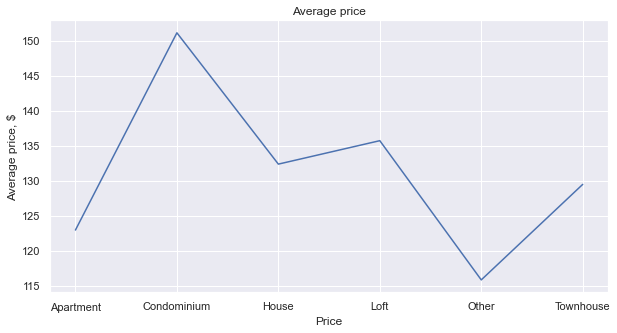

In [113]:
# Analysing trend of average prices of various property types

average_price_by_property = listings_df.groupby(['property_type'])['price'].mean()

plt.figure(figsize=(10,5))
plt.plot(average_price_by_property)
plt.ylabel('Average price, $')
plt.xlabel('Price')
plt.title('Average price')

plt.savefig('average price for property type')

plt.show()


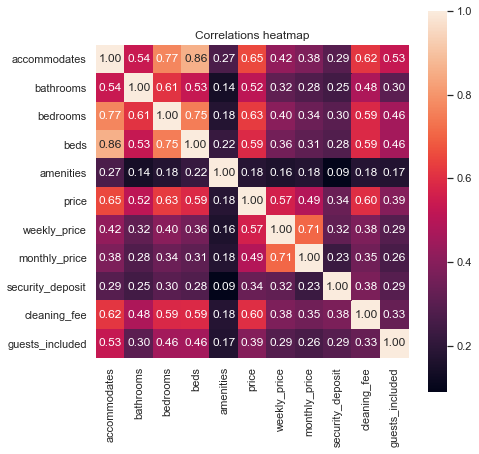

In [114]:
# Finding correlations between prices of accomodations and various amenities,bedrooms and bathrooms

property_type = ['accommodates', 'bathrooms', 'bedrooms', 'beds','amenities', 'price', 'weekly_price','monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included']
corrs = np.corrcoef(listings_df[property_type].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = property_type, xticklabels = property_type).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')


In [115]:
# Machine learning to predict prices by using Random Forest Regressors

drop_columns2 = ['price','property_type','room_type','bed_type','cancellation_policy','security_deposit', 'cleaning_fee', 'guests_included','extra_people', 'maximum_nights','square_feet','host_is_superhost']
X = listings_df.drop(drop_columns2,axis = 1)
y = listings_df[['price']]

TEST_SIZE = 0.3
RAND_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [116]:
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 402.997, test: 2544.181
Random Forest R^2 train: 0.949, test: 0.703


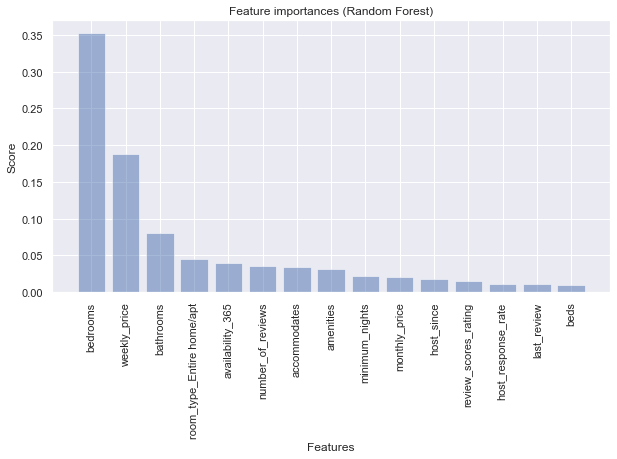

In [100]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()